In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([1, 1]) torch.Size([1, 1])


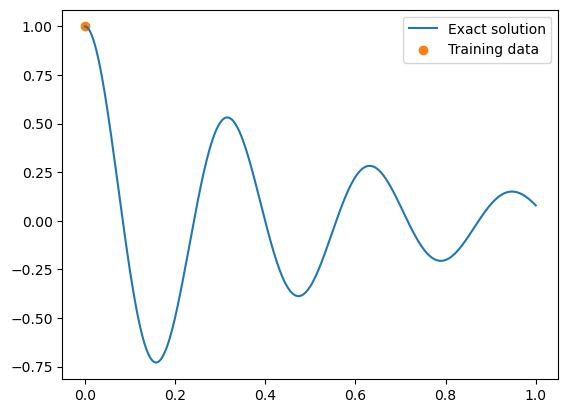

In [3]:
   
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
L = 60
size=0
x_data = x[0:L*size+1:L]#x[0:200:20]
y_data = y[0:L*size+1:L]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

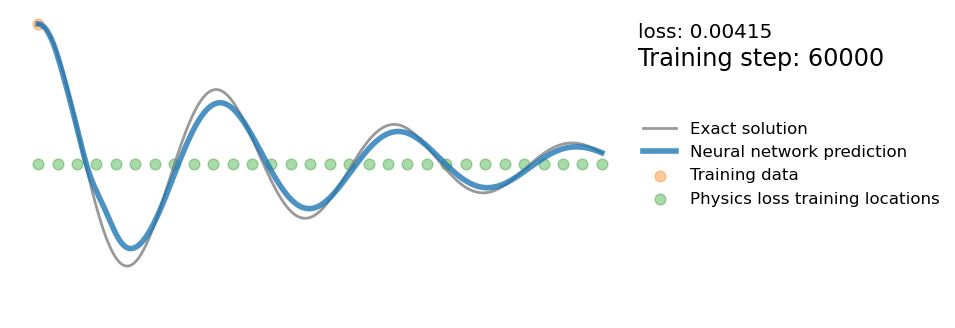

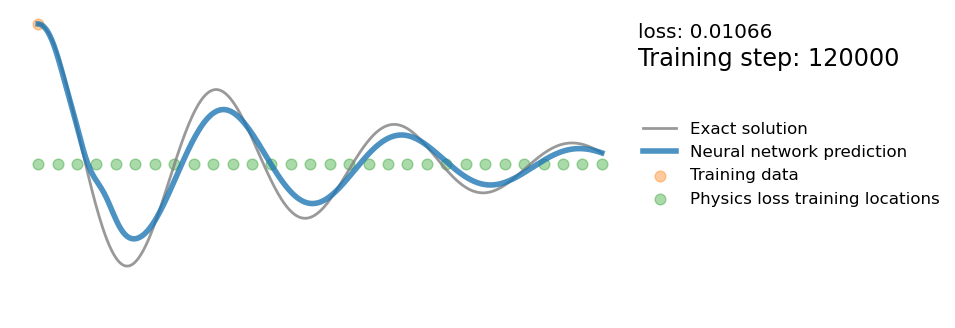

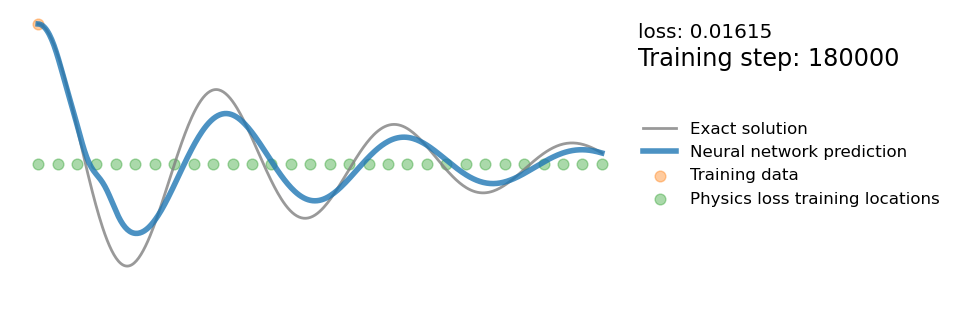

In [4]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.text(1.065,0.9,f"loss: {np.mean(((y-yh).numpy())**2):.5f}",fontsize="x-large",color="k")
    plt.axis("off")
    
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2
dx0 = 0


torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(4*50000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)#(1e-4)*torch.mean(physics**2)
    loss3 = (1e-1)*(dx0 - dx[0])**2

    
    # backpropagate joint loss
    loss = loss1 + loss2 + loss3 # add three loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh,xp)
        
        file = "./plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 20000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("pinn.gif", files, fps=20, loop=0)

In [2]:
!jupyter contrib nbextension install --sys-prefix

[I 13:24:18 InstallContribNbextensionsApp] jupyter contrib nbextension install --sys-prefix
[I 13:24:18 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 13:24:18 InstallContribNbextensionsApp] Installing /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/highlighter -> highlighter
[I 13:24:18 InstallContribNbextensionsApp] Making directory: /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/highlighter/
[I 13:24:18 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/highlighter/icon.png -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/highlighter/icon.png
[I 13:24:18 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/highlighter/highlighter.c

[I 13:24:20 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/hide_input/readme.md -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/hide_input/readme.md
[I 13:24:20 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/hide_input/hide-input.yaml -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/hide_input/hide-input.yaml
[I 13:24:21 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/hide_input/main.js -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/hide_input/main.js
[I 13:24:21 InstallContribNbextensionsApp] - Validating: OK
[I 13:24:21 InstallContribNbextensionsApp] Installing /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyt

[I 13:24:23 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/help_panel/help_panel_ext.png -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/help_panel/help_panel_ext.png
[I 13:24:23 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/help_panel/help_panel.css -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/help_panel/help_panel.css
[I 13:24:23 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/help_panel/help_panel_ext_fullscreen.png -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/help_panel/help_panel_ext_fullscreen.png
[I 13:24:23 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter

[I 13:24:25 InstallContribNbextensionsApp] - Validating: OK
[I 13:24:25 InstallContribNbextensionsApp] Installing /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/autosavetime -> autosavetime
[I 13:24:25 InstallContribNbextensionsApp] Making directory: /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/autosavetime/
[I 13:24:25 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/autosavetime/icon.png -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/autosavetime/icon.png
[I 13:24:25 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/autosavetime/README.md -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/autosavetime/README.md
[I 13:24:25 InstallContribNbextensionsApp] Copying: /end/home/rh23

[I 13:24:28 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/scratchpad/LICENSE -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/scratchpad/LICENSE
[I 13:24:28 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/scratchpad/scratchpad.css -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/scratchpad/scratchpad.css
[I 13:24:28 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/scratchpad/demo.gif -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/scratchpad/demo.gif
[I 13:24:29 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/scratchpad/main.js -> /end/ho

[I 13:24:32 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/limit_output/readme.md -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/limit_output/readme.md
[I 13:24:32 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/limit_output/main.js -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/limit_output/main.js
[I 13:24:33 InstallContribNbextensionsApp] - Validating: OK
[I 13:24:33 InstallContribNbextensionsApp] Installing /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/zenmode -> zenmode
[I 13:24:33 InstallContribNbextensionsApp] Making directory: /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/zenmode/
[I 13:24:33 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/py

[I 13:24:35 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/snippets_menu/config.yaml -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/snippets_menu/config.yaml
[I 13:24:35 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/snippets_menu/snippets_submenu_python.js -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/snippets_menu/snippets_submenu_python.js
[I 13:24:36 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/snippets_menu/main.js -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/snippets_menu/main.js
[I 13:24:36 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbexten

[I 13:24:38 InstallContribNbextensionsApp] - Validating: OK
[I 13:24:38 InstallContribNbextensionsApp] Installing /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/printview -> printview
[I 13:24:38 InstallContribNbextensionsApp] Making directory: /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/printview/
[I 13:24:38 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/printview/icon.png -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/printview/icon.png
[I 13:24:38 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/printview/printview-button.png -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/printview/printview-button.png
[I 13:24:38 InstallContribNbextensionsApp] Copying: /end/home/rh2

[I 13:24:39 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/exercise/main.js -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/exercise/main.js
[I 13:24:39 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/exercise/image.gif -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/exercise/image.gif
[I 13:24:39 InstallContribNbextensionsApp] - Validating: OK
[I 13:24:39 InstallContribNbextensionsApp] Installing /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/comment-uncomment -> comment-uncomment
[I 13:24:39 InstallContribNbextensionsApp] Making directory: /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/comment-uncomment/
[I 13:24:39 InstallContribNbextensionsApp] Copying: /end/home/rh2310/

[I 13:24:42 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/keyboard_shortcut_editor/keyboard_shortcut_editor.yaml -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/keyboard_shortcut_editor/keyboard_shortcut_editor.yaml
[I 13:24:42 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/keyboard_shortcut_editor/readme_conflict.png -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/keyboard_shortcut_editor/readme_conflict.png
[I 13:24:42 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/keyboard_shortcut_editor/main.js -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/keyboard_shortcut_editor/main.js
[I 13:24:42 InstallContribNbextensionsApp] Copying: /

[I 13:24:44 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/runtools/annotations.odg -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/runtools/annotations.odg
[I 13:24:44 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/runtools/runtools_nb.png -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/runtools/runtools_nb.png
[I 13:24:44 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/runtools/demo.gif -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/runtools/demo.gif
[I 13:24:45 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/runtools/runtools_marke

[I 13:24:47 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/varInspector/main.js -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/varInspector/main.js
[I 13:24:47 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/varInspector/varInspector.yaml -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/varInspector/varInspector.yaml
[I 13:24:47 InstallContribNbextensionsApp] Making directory: /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/varInspector/__pycache__
[I 13:24:47 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/varInspector/__pycache__/var_list.cpython-311.pyc -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/varInspector/__

[I 13:24:49 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/codefolding/readme.md -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/codefolding/readme.md
[I 13:24:49 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/codefolding/codefolding_indent_folded_2.png -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/codefolding/codefolding_indent_folded_2.png
[I 13:24:49 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/codefolding/codefolding_editor.yaml -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/codefolding/codefolding_editor.yaml
[I 13:24:49 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packag

[I 13:24:50 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/code_prettify/autopep8.yaml -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/code_prettify/autopep8.yaml
[I 13:24:50 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/code_prettify/README_2to3.md -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/code_prettify/README_2to3.md
[I 13:24:50 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/code_prettify/kernel_exec_on_cell.js -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/code_prettify/kernel_exec_on_cell.js
[I 13:24:50 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contr

[I 13:24:52 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/gist_it/gist_it.yaml -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/gist_it/gist_it.yaml
[I 13:24:52 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/gist_it/readme.md -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/gist_it/readme.md
[I 13:24:52 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/gist_it/main.js -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/gist_it/main.js
[I 13:24:52 InstallContribNbextensionsApp] - Validating: OK
[I 13:24:52 InstallContribNbextensionsApp] Installing /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/

[I 13:24:55 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/hinterland/hinterland.js -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/hinterland/hinterland.js
[I 13:24:55 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/hinterland/hinterland.yaml -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/hinterland/hinterland.yaml
[I 13:24:55 InstallContribNbextensionsApp] - Validating: OK
[I 13:24:55 InstallContribNbextensionsApp] Installing /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/exercise2 -> exercise2
[I 13:24:55 InstallContribNbextensionsApp] Making directory: /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/exercise2/
[I 13:24:55 InstallContribNbextensionsApp] Copying: /end/home

[I 13:24:57 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/collapsible_headings/screenshot.png -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/collapsible_headings/screenshot.png
[I 13:24:57 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/collapsible_headings/main.css -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/collapsible_headings/main.css
[I 13:24:57 InstallContribNbextensionsApp] Copying: /end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/jupyter_contrib_nbextensions/nbextensions/collapsible_headings/main.js -> /end/home/rh2310/.conda/envs/pytorch/share/jupyter/nbextensions/collapsible_headings/main.js
[I 13:24:57 InstallContribNbextensionsApp] - Validating: OK
[I 13:24:57 InstallContribNbextensionsApp] Installing /end/home/rh231